In [1]:
# %%
import itertools
from typing import Sequence

from infrastructure.interrupt import InterruptHandler

from experiment import experiment_relu_kan, experiment_spec
from experiment.kan import conv_2d_relu_kan
from experiment.kan.conv_2d_spec import KanSpec

data_version = 'v2'
data_source = experiment_relu_kan.version_to_data_source[data_version]
print(
    data_version,
    'train:',
    data_source.get_fold_size('train'),
    'valid:',
    data_source.get_fold_size('test'),
)


def train_func(num_block_repeats: Sequence[int]) -> None:
    assert all(isinstance(ni, int) and ni > 0 for ni in num_block_repeats)

    num_block_types = len(num_block_repeats)
    assert num_block_types > 0
    assert all(repeats > 0 for repeats in num_block_repeats)

    downsample_first_block = False

    args = experiment_relu_kan.TrainArgs(
        data_version=data_version,
        augment=True,
        lr=1e-4,
        weight_decay=1e-2,
        weight_decay_splines=False,
        batch_len=32,
        model_cls=conv_2d_relu_kan.ResConv2dReLUKAN,
        model_spec=experiment_spec.Conv2dModelSpecRepr(
            input_shape=data_source.input_shape,
            input_channels=data_source.num_channels,
            output_channels=data_source.num_classes,
            blocks_kernel=[(3, 3)] * sum(num_block_repeats),
            blocks_stride=list(
                itertools.chain(
                    *(
                        (
                            [(1, 1)] * repeats
                            if i == 0 and not downsample_first_block
                            else [(2, 2)] + [(1, 1)] * (repeats - 1)
                        )
                        for i, repeats in enumerate(num_block_repeats)
                    )
                )
            ),
            blocks_padding=[(1, 1)] * sum(num_block_repeats),
            blocks_channels=[
                16 * 2**i
                for i, repeats in enumerate(num_block_repeats)
                for _ in range(repeats)
            ],
            blocks_channels_interact=[True] * sum(num_block_repeats),
            blocks_num_layers=[2] * sum(num_block_repeats),
            blocks_use_batch_norm=[True] * sum(num_block_repeats),
            kan_spec=KanSpec(g=5, k=3, center_zero=True, scale=0.375),
        ),
    )

    with InterruptHandler() as interrupt_handler:
        experiment_relu_kan.train(
            args, interrupt_handler=interrupt_handler, seed=42
        )

v2 train: 50000 valid: 10000


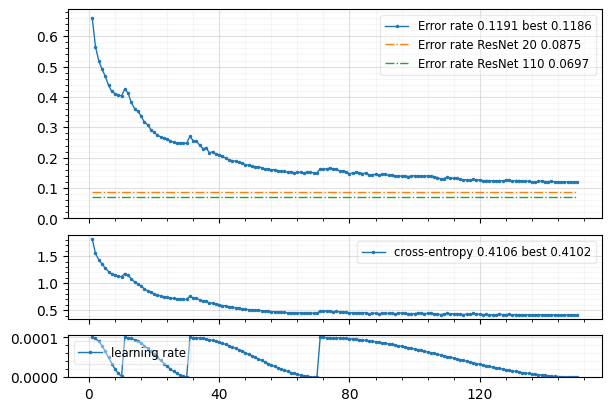

train epoch 150:   0%|          | 0/1563 [00:00<?, ?it/s]

In [2]:
# %%
train_func([2, 1, 1, 1])

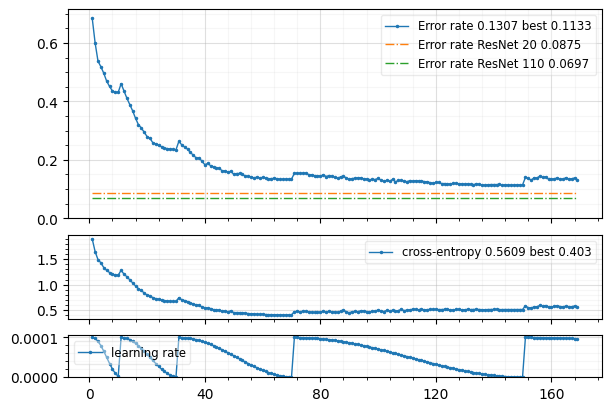

train epoch 169:   0%|          | 0/1563 [00:00<?, ?it/s]

In [3]:
# %%
train_func([3, 2, 2, 2])

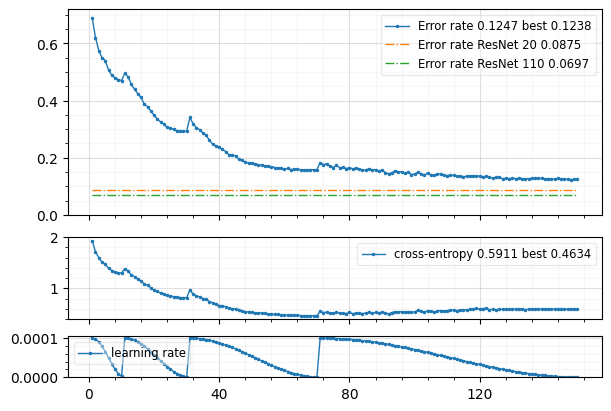

train epoch 150:   0%|          | 0/1563 [00:00<?, ?it/s]

In [4]:
# %%
train_func([4, 3, 3, 3])

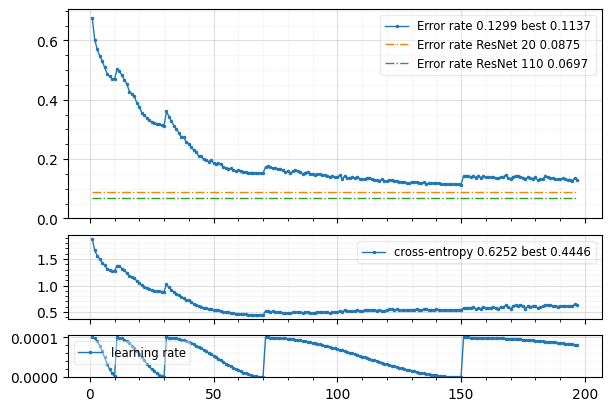

train epoch 197:   0%|          | 0/1563 [00:00<?, ?it/s]

In [5]:
# %%
train_func([5, 4, 4, 4])

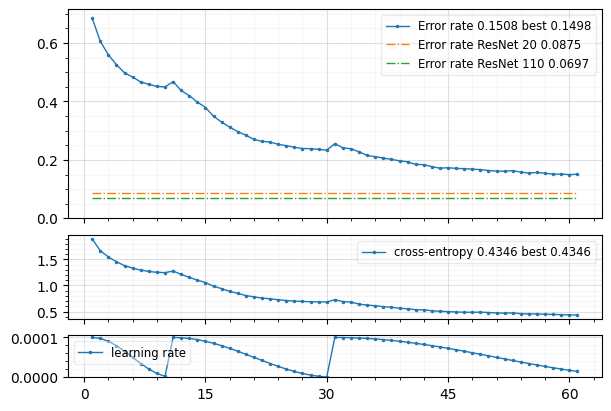

train epoch 61:   0%|          | 0/1563 [00:00<?, ?it/s]

In [6]:
train_func((4, 1, 1, 1))